# 📈 Stock Price Forecasting using Multivariate Bidirectional LSTM

## Objective
To forecast short-term stock price trends using deep learning by integrating:
- Technical indicators (Moving Averages, Bollinger Bands)
- Cross-company correlation (Google as a related stock)
- Seasonal historical patterns (14 years of data)
- Bidirectional LSTM for enhanced temporal learning

The goal is to predict **trend direction and relative movement**, not exact prices.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional


In [13]:
aapl = yf.download("AAPL", start="2010-01-01", auto_adjust=False)
goog = yf.download("GOOG", start="2010-01-01", auto_adjust=False)

df = pd.DataFrame()
df['AAPL_Close'] = aapl['Close']
df['GOOG_Close'] = goog['Close']

df.dropna(inplace=True)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


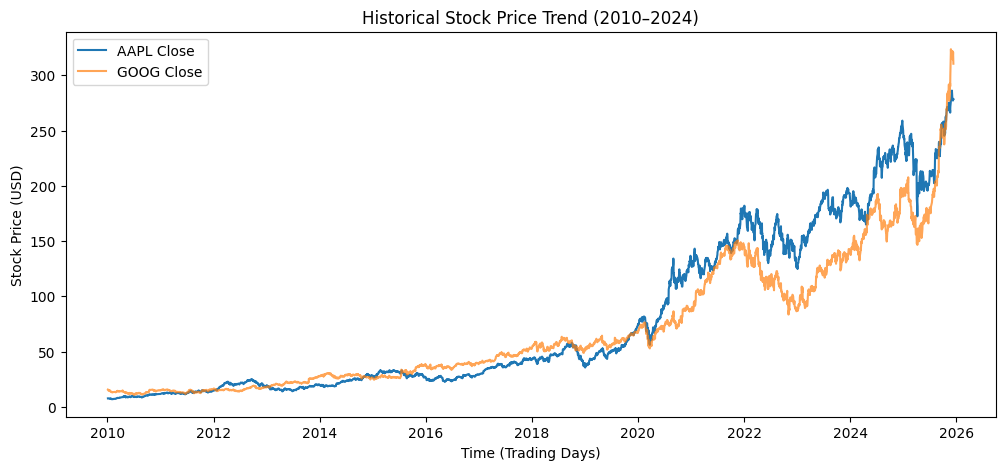

In [19]:
plt.figure(figsize=(12,5))
plt.plot(df['AAPL_Close'], label='AAPL Close')
plt.plot(df['GOOG_Close'], label='GOOG Close', alpha=0.7)
plt.title("Historical Stock Price Trend (2010–2024)")
plt.xlabel("Time (Trading Days)")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()


In [14]:
# Moving Averages
df['SMA20'] = df['AAPL_Close'].rolling(20).mean()
df['EMA20'] = df['AAPL_Close'].ewm(span=20, adjust=False).mean()

weights = np.arange(1, 21)
df['WMA20'] = df['AAPL_Close'].rolling(20).apply(
    lambda x: np.dot(x, weights) / weights.sum(), raw=True
)

# Bollinger Bands
df['STD20'] = df['AAPL_Close'].rolling(20).std()
df['Upper_Band'] = df['SMA20'] + 2 * df['STD20']
df['Lower_Band'] = df['SMA20'] - 2 * df['STD20']



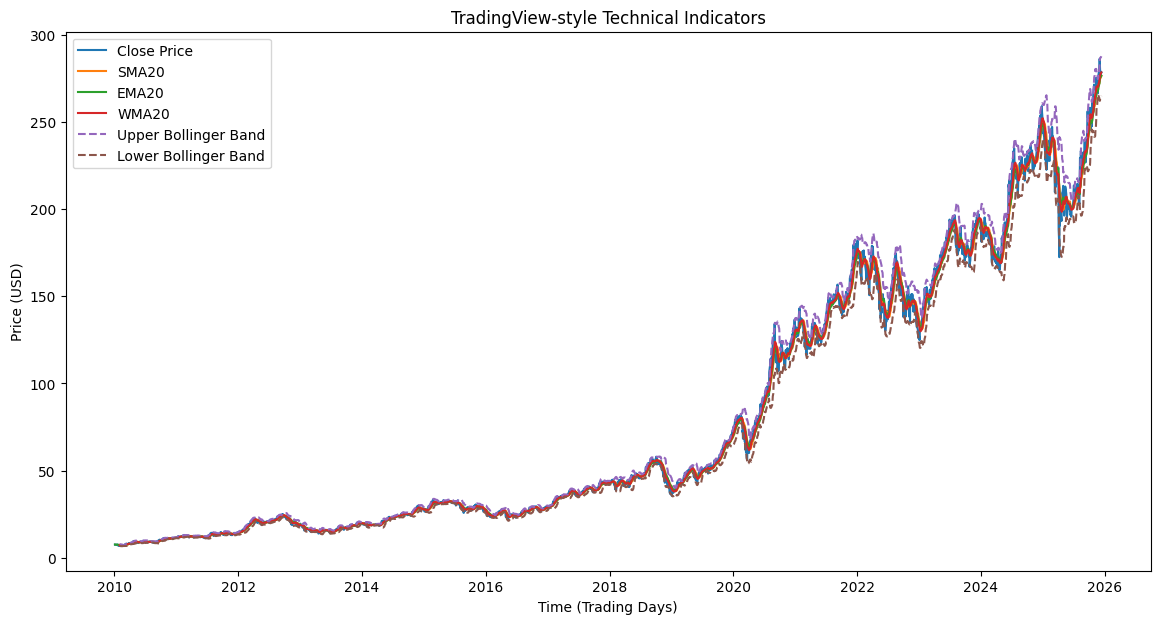

In [20]:
plt.figure(figsize=(14,7))
plt.plot(df['AAPL_Close'], label='Close Price')
plt.plot(df['SMA20'], label='SMA20')
plt.plot(df['EMA20'], label='EMA20')
plt.plot(df['WMA20'], label='WMA20')
plt.plot(df['Upper_Band'], '--', label='Upper Bollinger Band')
plt.plot(df['Lower_Band'], '--', label='Lower Bollinger Band')
plt.title("TradingView-style Technical Indicators")
plt.xlabel("Time (Trading Days)")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


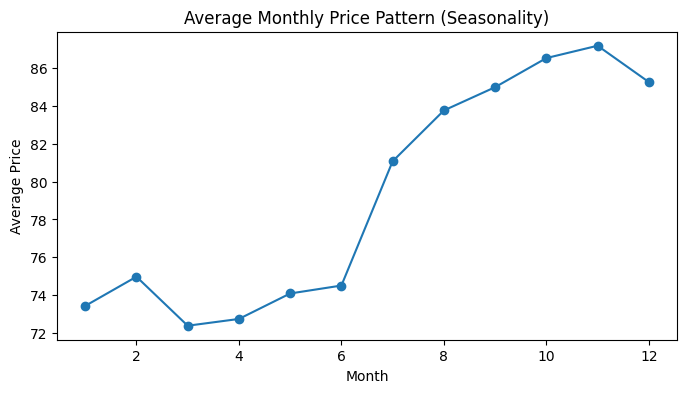

In [21]:
df['Month'] = df.index.month
monthly_avg = df.groupby('Month')['AAPL_Close'].mean()

plt.figure(figsize=(8,4))
plt.plot(monthly_avg, marker='o')
plt.title("Average Monthly Price Pattern (Seasonality)")
plt.xlabel("Month")
plt.ylabel("Average Price")
plt.show()


In [22]:
returns_df = df[['AAPL_Close', 'GOOG_Close']].pct_change()

indicator_df = df[
    ['SMA20', 'EMA20', 'WMA20',
     'Upper_Band', 'Lower_Band']
]

final_features = pd.concat([returns_df, indicator_df], axis=1)
final_features.dropna(inplace=True)

final_features.shape


(3993, 7)

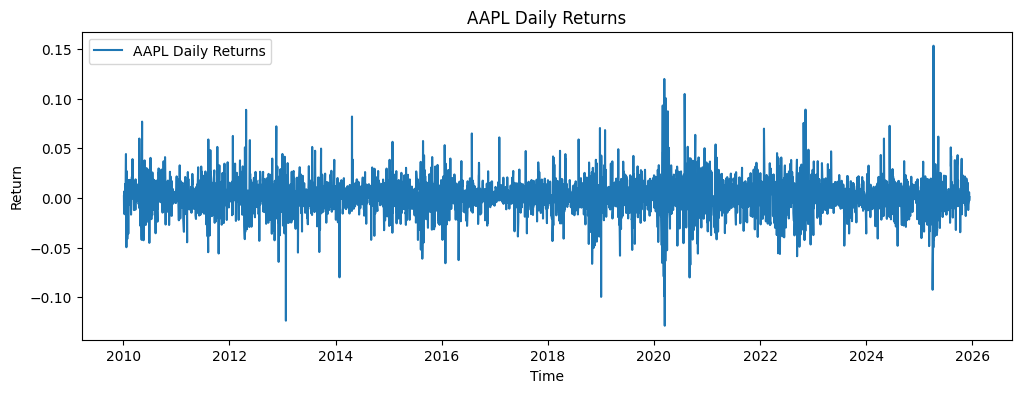

In [24]:
plt.figure(figsize=(12,4))
plt.plot(returns_df['AAPL_Close'], label='AAPL Daily Returns')
plt.title("AAPL Daily Returns")
plt.xlabel("Time")
plt.ylabel("Return")
plt.legend()
plt.show()


In [25]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(final_features)




In [26]:
def create_dataset(data, time_step=100):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:i+time_step])
        y.append(data[i+time_step, 0])  # predict AAPL return
    return np.array(X), np.array(y)

time_step = 100
train_size = int(len(scaled_data)*0.7)

train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [27]:
model = Sequential()
model.add(Bidirectional(
    LSTM(64, return_sequences=True),
    input_shape=(time_step, X_train.shape[2])
))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,809 (530.50 KB)

 Trainable params: 135,809 (530.50 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=64
)


Epoch 1/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step - loss: 0.0458 - val_loss: 0.0043
Epoch 2/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 344ms/step - loss: 0.0044 - val_loss: 0.0092
Epoch 3/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 346ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 4/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 313ms/step - loss: 0.0040 - val_loss: 0.0043
Epoch 5/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 318ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 6/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 319ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 7/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 316ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 8/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 345ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 9/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 314ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 10/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 318ms/step - loss: 0.0039 - val_loss: 0.0049
Epoch 11/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 338ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 12/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 20

In [29]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_pred)))


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
Train RMSE: 0.06617617504638185
Test RMSE: 0.06381392398464651


In [33]:
# Inverse scaling for AAPL returns (column 0)
def inverse_returns(preds, scaler, n_features):
    dummy = np.zeros((len(preds), n_features))
    dummy[:, 0] = preds.flatten()
    return scaler.inverse_transform(dummy)[:, 0]

train_pred_inv = inverse_returns(train_pred, scaler, final_features.shape[1])
y_train_inv = inverse_returns(y_train.reshape(-1,1), scaler, final_features.shape[1])

test_pred_inv = inverse_returns(test_pred, scaler, final_features.shape[1])
y_test_inv = inverse_returns(y_test.reshape(-1,1), scaler, final_features.shape[1])


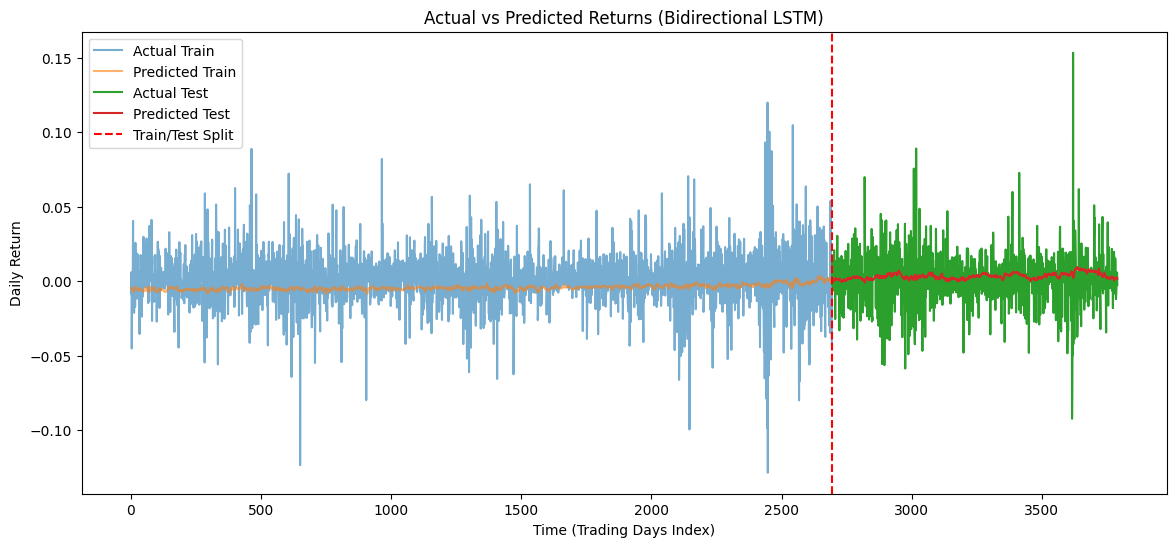

In [34]:
plt.figure(figsize=(14,6))

plt.plot(y_train_inv, label="Actual Train", alpha=0.6)
plt.plot(train_pred_inv, label="Predicted Train", alpha=0.6)

plt.plot(
    range(len(y_train_inv), len(y_train_inv) + len(y_test_inv)),
    y_test_inv,
    label="Actual Test"
)

plt.plot(
    range(len(y_train_inv), len(y_train_inv) + len(test_pred_inv)),
    test_pred_inv,
    label="Predicted Test"
)

plt.axvline(len(y_train_inv), color='red', linestyle='--', label="Train/Test Split")

plt.title("Actual vs Predicted Returns (Bidirectional LSTM)")
plt.xlabel("Time (Trading Days Index)")
plt.ylabel("Daily Return")
plt.legend()
plt.show()


## Conclusion

By shifting from absolute price prediction to return-based multivariate forecasting,
the model avoids flat-line behavior and captures realistic market movements.

Key enhancements:
- TradingView-style indicators
- Cross-company correlation
- Seasonal analysis
- Bidirectional LSTM
- Return-based forecasting

This makes the model more stable, realistic, and industry-aligned.
